In [1]:
from NewLibraryENG import *

In [2]:
import glob
list_dir=glob.glob("/Users/Gaia_1/Desktop/h5files/*.h5")

In [3]:
fs = 10000 #Sampling Frequency
all_data=[]
all_ref=[]
for file in tqdm(list_dir):
    string=file
    data=h5py.File(string,'r')
    data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
    info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
    info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
    labels = info_table['Label']
    readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
    ref=readings[b'Ref']
    len_data=int(len(readings)/6)
    readings=readings.iloc[0:len_data, 17:23]
    ref=ref[0:len_data]
    #readings=readings.drop([b'Ref'],axis=1)
    all_ref.append(ref)
    print(readings.shape)
    all_data.append(readings)

  0%|          | 0/4 [00:00<?, ?it/s]

(750500, 6)
(701666, 6)
(704666, 6)
(601833, 6)


In [4]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filtered_all_data=[]
for file in tqdm(range(len(all_data))):
    prova=all_data[file]
    ref=all_ref[file]
    prova_rows = range(prova.shape[0])
    filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
    filt_ref=filtfilt(b,a,ref)
    for x in tqdm(range(prova.shape[1])):
        filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
    for electrode in tqdm(prova.columns):
        filt_prova[electrode] = filt_prova[electrode] - filt_ref
    filtered_all_data.append(filt_prova)
    filt_prova.shape

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Detection

In [5]:
pos_ind=[]
neg_ind=[]
for file in tqdm(range(len(filtered_all_data))):
    pos_ind_file=[]
    neg_ind_file=[]
    prova=filtered_all_data[file]
    for electrode in tqdm(prova.columns):
        channel=prova[electrode]
        pos, neg=find_all_spikes(channel)
        pos_ind_file.append(pos)
        neg_ind_file.append(neg)
    pos_ind.append(pos_ind_file)
    neg_ind.append(neg_ind_file)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/740500 [00:00<?, ?it/s]

positive spikes 1337 negative spikes 5962 detected spikes: 7299 firing rate:  97.25516322451699


  0%|          | 0/740500 [00:00<?, ?it/s]

positive spikes 1315 negative spikes 5747 detected spikes: 7062 firing rate:  94.09726848767488


  0%|          | 0/740500 [00:00<?, ?it/s]

positive spikes 1329 negative spikes 6158 detected spikes: 7487 firing rate:  99.76015989340439


  0%|          | 0/740500 [00:00<?, ?it/s]

positive spikes 1375 negative spikes 5908 detected spikes: 7283 firing rate:  97.04197201865423


  0%|          | 0/740500 [00:00<?, ?it/s]

positive spikes 1396 negative spikes 6149 detected spikes: 7545 firing rate:  100.53297801465689


  0%|          | 0/740500 [00:00<?, ?it/s]

positive spikes 1342 negative spikes 5878 detected spikes: 7220 firing rate:  96.20253164556962


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/691666 [00:00<?, ?it/s]

positive spikes 1266 negative spikes 2606 detected spikes: 3872 firing rate:  55.182950292589354


  0%|          | 0/691666 [00:00<?, ?it/s]

positive spikes 1282 negative spikes 2298 detected spikes: 3580 firing rate:  51.02142614862342


  0%|          | 0/691666 [00:00<?, ?it/s]

positive spikes 1202 negative spikes 2305 detected spikes: 3507 firing rate:  49.98104511263194


  0%|          | 0/691666 [00:00<?, ?it/s]

positive spikes 1201 negative spikes 2379 detected spikes: 3580 firing rate:  51.02142614862342


  0%|          | 0/691666 [00:00<?, ?it/s]

positive spikes 1693 negative spikes 2966 detected spikes: 4659 firing rate:  66.39911296827836


  0%|          | 0/691666 [00:00<?, ?it/s]

positive spikes 1964 negative spikes 2854 detected spikes: 4818 firing rate:  68.66514837543788


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/694666 [00:00<?, ?it/s]

positive spikes 773 negative spikes 5928 detected spikes: 6701 firing rate:  95.09469734597667


  0%|          | 0/694666 [00:00<?, ?it/s]

positive spikes 684 negative spikes 5754 detected spikes: 6438 firing rate:  91.36243269861183


  0%|          | 0/694666 [00:00<?, ?it/s]

positive spikes 647 negative spikes 6005 detected spikes: 6652 firing rate:  94.39933244969957


  0%|          | 0/694666 [00:00<?, ?it/s]

positive spikes 686 negative spikes 5590 detected spikes: 6276 firing rate:  89.06347120479774


  0%|          | 0/694666 [00:00<?, ?it/s]

positive spikes 694 negative spikes 6021 detected spikes: 6715 firing rate:  95.29337303062728


  0%|          | 0/694666 [00:00<?, ?it/s]

positive spikes 704 negative spikes 6063 detected spikes: 6767 firing rate:  96.03131128790093


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/591833 [00:00<?, ?it/s]

positive spikes 980 negative spikes 1026 detected spikes: 2006 firing rate:  33.3315055837749


  0%|          | 0/591833 [00:00<?, ?it/s]

positive spikes 978 negative spikes 1062 detected spikes: 2040 firing rate:  33.896446356381254


  0%|          | 0/591833 [00:00<?, ?it/s]

positive spikes 966 negative spikes 1032 detected spikes: 1998 firing rate:  33.19857834316164


  0%|          | 0/591833 [00:00<?, ?it/s]

positive spikes 1010 negative spikes 1023 detected spikes: 2033 firing rate:  33.780135020844654


  0%|          | 0/591833 [00:00<?, ?it/s]

positive spikes 3498 negative spikes 4971 detected spikes: 8469 firing rate:  140.72010009421217


  0%|          | 0/591833 [00:00<?, ?it/s]

positive spikes 3593 negative spikes 5520 detected spikes: 9113 firing rate:  151.42074296357958


# Cutouts

In [6]:
pos_cut=[]
neg_cut=[]
n_pos=[]
n_neg=[]
for file in tqdm(range(len(filtered_all_data))):
    pos_cut_file=[]
    neg_cut_file=[]
    n_pos_file=[]
    n_neg_file=[]
    prova=filtered_all_data[file]
    pos_ind_file=pos_ind[file]
    neg_ind_file=neg_ind[file]
    for i,electrode in enumerate(tqdm(prova.columns)):
        pos=pos_ind_file[i]
        neg=neg_ind_file[i]
        channel=prova[electrode]
        pos_cut1,n_pos1, neg_cut1,n_neg1 = cut(pos,neg,channel)
        pos_cut_file.append(pos_cut1)
        neg_cut_file.append(neg_cut1)
        n_pos_file.append(n_pos1)
        n_neg_file.append(n_neg1)
    pos_cut.append(pos_cut_file)
    neg_cut.append(neg_cut_file)
    n_pos.append(n_pos_file)
    n_neg.append(n_neg_file)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

0 1337 1337 0 5962 5962
0 1314 1314 0 5747 5747
0 1329 1329 0 6158 6158
0 1375 1375 0 5907 5907
0 1396 1396 0 6149 6149
0 1342 1342 0 5878 5878


  0%|          | 0/6 [00:00<?, ?it/s]

0 1266 1266 0 2606 2606
0 1282 1282 0 2298 2298
0 1202 1202 0 2305 2305
0 1200 1200 0 2379 2379
0 1693 1693 0 2966 2966
0 1964 1964 0 2854 2854


  0%|          | 0/6 [00:00<?, ?it/s]

0 773 773 0 5928 5928
0 684 684 0 5754 5754
0 647 647 0 6005 6005
0 686 686 0 5590 5590
0 694 694 0 6021 6021
0 704 704 0 6063 6063


  0%|          | 0/6 [00:00<?, ?it/s]

0 980 980 0 1026 1026
0 978 978 0 1062 1062
0 966 966 0 1032 1032
0 1010 1010 0 1022 1022
0 3498 3498 0 4971 4971
0 3593 3593 0 5520 5520


# Clustering

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Total spikes:  1337

______________________________________________________________________________________________________________
For 2 clusters, the silhouette score is: 0.143 CH score 231.475 DB score 2.346



______________________________________________________________________________________________________________
For 3 clusters, the silhouette score is: 0.019 CH score 116.663 DB score 2.117



______________________________________________________________________________________________________________
For 4 clusters, the silhouette score is: 0.068 CH score 97.578 DB score 2.738



______________________________________________________________________________________________________________
For 5 clusters, the silhouette score is: 0.074 CH score 83.648 DB score 4.295



______________________________________________________________________________________________________________
For 6 clusters, the silhouette score is: -0.070 CH score 59.695 DB score 2.753




Best cluster in

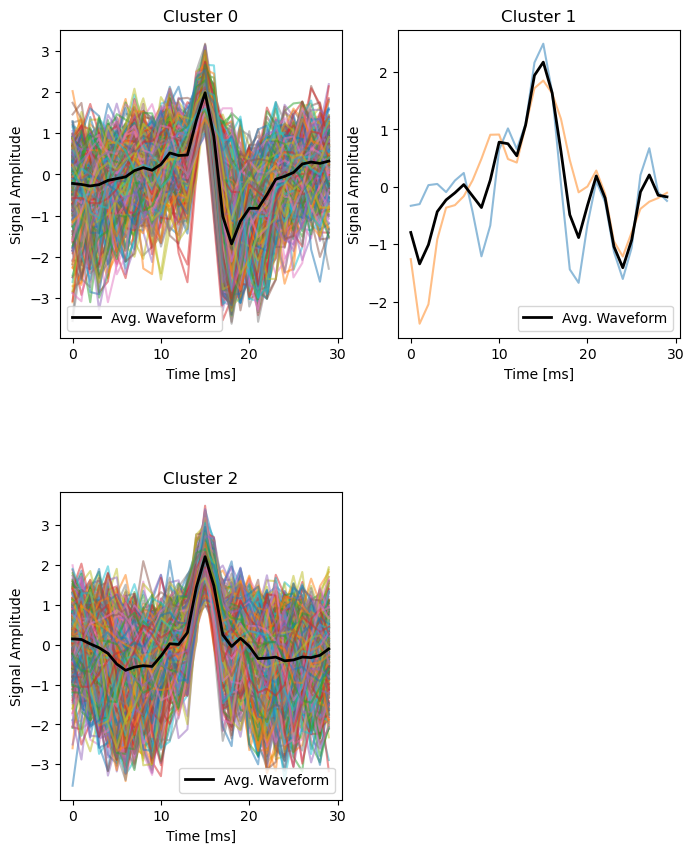

0
1
2


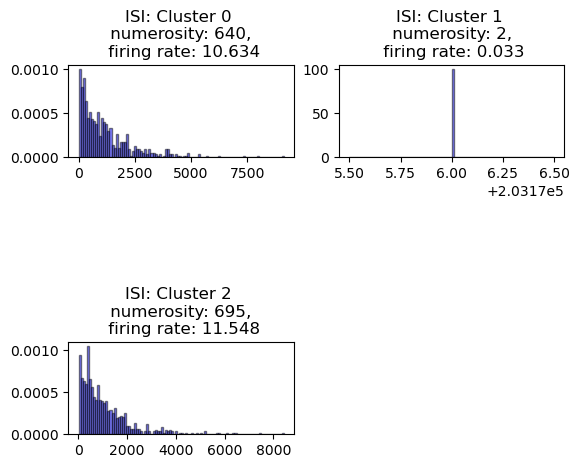

Total spikes:  1314

______________________________________________________________________________________________________________
For 2 clusters, the silhouette score is: 0.150 CH score 244.085 DB score 2.255



______________________________________________________________________________________________________________
For 3 clusters, the silhouette score is: 0.068 CH score 126.093 DB score 2.896



______________________________________________________________________________________________________________
For 4 clusters, the silhouette score is: 0.077 CH score 123.743 DB score 1.938



______________________________________________________________________________________________________________
For 5 clusters, the silhouette score is: -0.014 CH score 83.020 DB score 1.857



______________________________________________________________________________________________________________
For 6 clusters, the silhouette score is: -0.013 CH score 64.286 DB score 2.564




Best cluster 

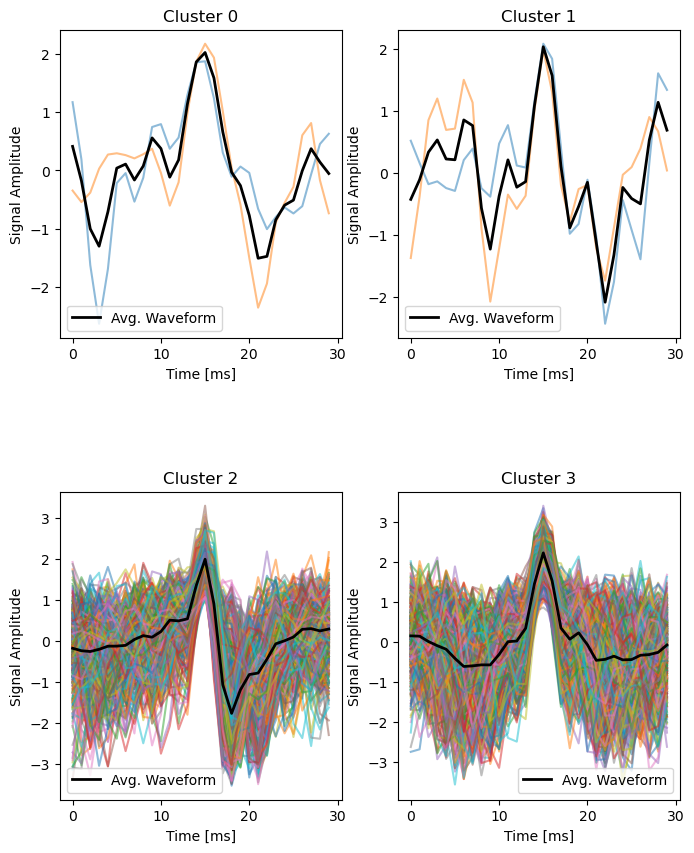

0
1
2
3


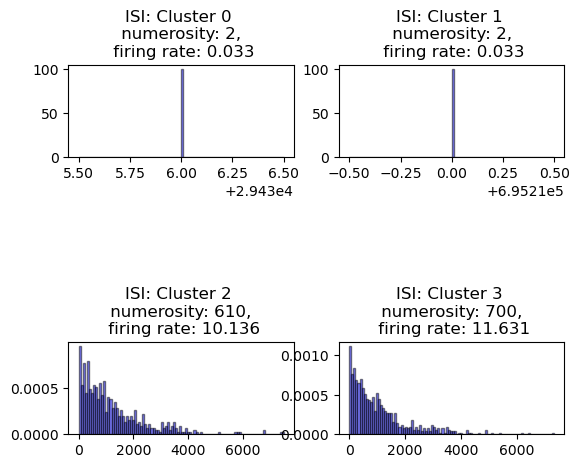

Total spikes:  1329

______________________________________________________________________________________________________________
For 2 clusters, the silhouette score is: 0.152 CH score 248.917 DB score 2.246



______________________________________________________________________________________________________________
For 3 clusters, the silhouette score is: 0.006 CH score 125.682 DB score 2.097



______________________________________________________________________________________________________________
For 4 clusters, the silhouette score is: -0.080 CH score 84.089 DB score 1.871



______________________________________________________________________________________________________________
For 5 clusters, the silhouette score is: -0.067 CH score 84.334 DB score 1.980



______________________________________________________________________________________________________________
For 6 clusters, the silhouette score is: -0.016 CH score 84.651 DB score 2.243




Best cluster 

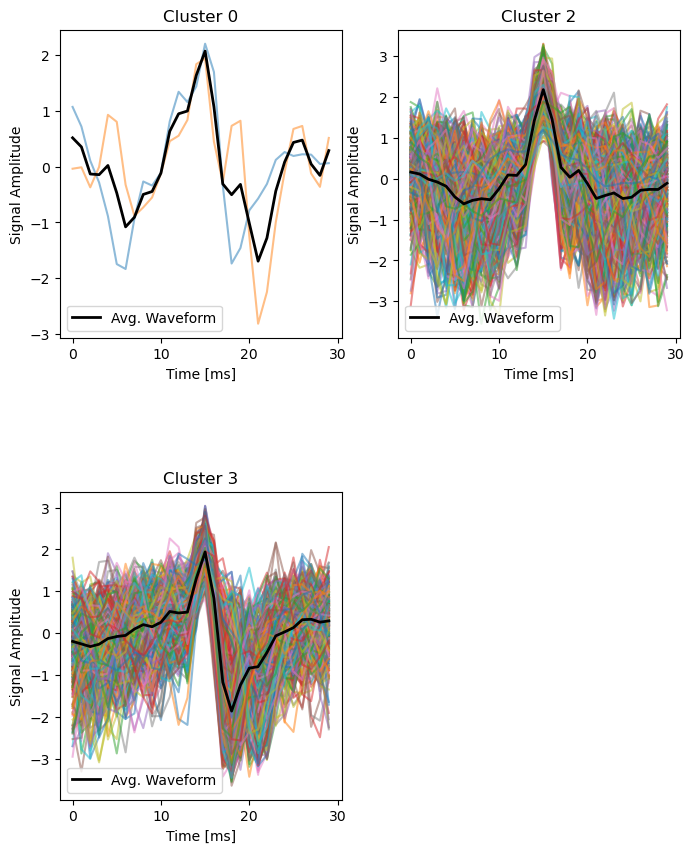

0
2


IndexError: list index out of range

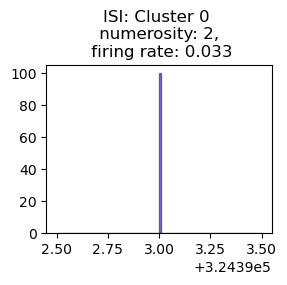

In [7]:
pos_clusters=[]
for file in tqdm(range(len(filtered_all_data))):
    pos_cut_file=pos_cut[file]
    n_pos_file=n_pos[file]
    final_data_pos=[]
    for channel in (tqdm(range(len(pos_cut)))):
        channel_clusters=clus(pos_cut_file[channel],'fuzzy',n_pos_file[channel],3,len_data)
        final_data_pos.append(channel_clusters)
    pos_clusters.append(final_data_pos)